In [5]:
import pathlib

import ndcube
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import wesanderson
import numpy as np
import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch, AsinhStretch, AsymmetricPercentileInterval
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
import astropy.table
import sunpy.map

from synthesizAR.instruments import InstrumentDEM
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import Channel, SpectrogramChannel
from mocksipipeline.util import stack_components, read_data_cube
from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes

Need to set a color palette for:

- spectral orders (5 colors)
- heating frequencies (2-4 colors)

In [505]:
spectral_palette = wesanderson.color_palettes['Darjeeling Limited'][0]
frequency_palette = wesanderson.color_palettes['Darjeeling Limited'][1]
filtergram_palette = wesanderson.color_palettes['Moonrise Kingdom'][2]

In [8]:
line_list = astropy.table.QTable.read('/Users/wtbarnes/Documents/projects/cubixss/moxsi-science-planning/data/moxsi-line-list.asdf')

In [746]:
data_dir = pathlib.Path('../data/')
observed_data_dir = data_dir / 'observations' / 'ar_2020-11-09T18:00:00.000'
simulated_data_dir = pathlib.Path('../pipeline/data/')

In [447]:
def add_arrow_from_coords(ax, tail, head, **arrow_kwargs):
    if tail.unit == u.pix:
        transform = 'pixel'
        end_unit = 'pixel'
    else:
        transform = 'world'
        end_unit = 'deg'
    arrow = matplotlib.patches.FancyArrowPatch(tail.to_value(end_unit),
                                               head.to_value(end_unit),
                                               transform=ax.get_transform(transform),
                                               **arrow_kwargs)
    ax.add_patch(arrow)
    

def turn_off_ticks_and_labels(ax, hide_ticks=True, hide_axislabel=True):
    for c in ax.coords:
        if hide_ticks:
            c.set_ticks_visible(False)
        c.set_ticklabel_visible(False)
        if hide_axislabel:
            c.set_auto_axislabel(False)

## Line Selection

In [356]:
intensity_thresh = 0.0
dem_set = 'flare_ext'
selected_ion_list = (
    #'Fe XVII',
    #'Fe XVIII',
    #'O VII',
    #'O VIII',
    #'Si XIII',
    'Fe XIX',
    #'Fe XX'
    #'Mg XI',
    #'Si XIV',
)
selected_lines = line_list[line_list[f'intensity_scaled (coronal)_{dem_set}']>intensity_thresh]
selected_lines = selected_lines[selected_lines.argsort(keys=f'intensity_scaled (coronal)_{dem_set}', reverse=True)]
selected_lines = selected_lines[['ion name', 'wavelength', 'ion id']]
#selected_lines = selected_lines[[r['ion name'] in selected_ion_list for r in selected_lines]][:20]
#selected_lines = selected_lines[:10]
#selected_lines = selected_lines[selected_lines['ion name']=='Fe XVII']

In [358]:
selected_lines[selected_lines['ion name']=='Fe XVIII']

ion name,wavelength,ion id
,Angstrom,
str9,float64,str5
Fe XVIII,14.203900337219238,fe_18
Fe XVIII,16.07200050354004,fe_18
Fe XVIII,14.208800315856934,fe_18
Fe XVIII,17.62179946899414,fe_18
Fe XVIII,16.0049991607666,fe_18
Fe XVIII,15.622099876403809,fe_18
Fe XVIII,14.373000144958496,fe_18
Fe XVIII,14.536999702453613,fe_18


In [357]:
selected_lines[np.logical_and(selected_lines['wavelength']>15.01*u.AA, selected_lines['wavelength']<16.5*u.AA)]

ion name,wavelength,ion id
,Angstrom,
str9,float64,str5
Fe XVII,15.012999534606934,fe_17
Fe XVIII,16.07200050354004,fe_18
Fe XVII,15.26200008392334,fe_17
Fe XVIII,16.0049991607666,fe_18
Fe XVIII,15.622099876403809,fe_18
Fe XIX,16.109899520874023,fe_19
Fe XVIII,15.82800006866455,fe_18
Fe XIX,15.081000328063965,fe_19


In [6]:
selected_wavelengths = [
    6.1803998947143555, # Si XIV
    6.647900104522705, # Si XIII
    14.668999671936035, # Fe XIX
    15.012999534606934, # Fe XVII
    17.051000595092773, # Fe XVII
    #17.09600067138672, # Fe XVII
    16.77560043334961, # Fe XVII
    16.07200050354004, # Fe XVII
    15.26200008392334, # Fe XVII
    12.82699966430664, # Fe XX
    18.967100143432617, # O VIII
    21.601499557495117, # O VII
    22.097700119018555, # O VII
    21.803600311279297, # O VII
    14.208800315856934, # Fe XVIII
    9.314299583435059, # Mg XI
    44.160301208496094, # Si XII
    13.524900436401367, # Fe XIX
    12.281999588012695, # Fe XXI
    #14.203900337219238, # Fe XVIII
] * u.AA

In [9]:
selected_lines = astropy.table.QTable(astropy.table.vstack([line_list[np.argmin(np.fabs(line_list['wavelength'] - w))] for w in selected_wavelengths]))

In [634]:
selected_lines

atomic number,ionization stage,transition,transition (latex),ion name,lower level,upper level,max temperature_flare_ext,wavelength,only theoretical_flare_ext,element,ion id,energy,abundance (coronal),abundance (photospheric),intensity (coronal)_flare_ext,intensity_scaled (coronal)_flare_ext,intensity (photospheric)_flare_ext,intensity_scaled (photospheric)_flare_ext,max temperature_active_region,only theoretical_active_region,intensity (coronal)_active_region,intensity_scaled (coronal)_active_region,intensity (photospheric)_active_region,intensity_scaled (photospheric)_active_region
,,,,,,,MK,Angstrom,,,,keV,,,ph / (cm2 s sr),,ph / (cm2 s sr),,MK,,ph / (cm2 s sr),,ph / (cm2 s sr),
int16,int16,str48,str93,str9,int16,int16,float32,float64,bool,str2,str5,float64,float64,float64,float64,float64,float64,float64,float32,bool,float64,float64,float64,float64
14,14,1s 2S1/2 - 2p 2P3/2,1s $^2$S$_{1/2}$ - 2p $^2$P$_{3/2}$,Si XIV,1,4,14.125378608703613,6.1803998947143555,False,Si,si_14,2.0060869934845944,0.0001258925411794166,3.235936569296281e-05,929295523027350.5,0.2479326087679569,238865729333548.8,0.24500329680440866,6.309576034545898,False,565342273.7672716,0.0002539968491682113,145315339.6312356,0.0001466667854033424
14,13,1s2 1S0 - 1s.2p 1P1,1s$^{2}$ $^1$S$_{0}$ - 1s 2p $^1$P$_{1}$,Si XIII,1,7,12.589250564575195,6.647900104522705,False,Si,si_13,1.8650129587364168,0.0001258925411794166,3.235936569296281e-05,893249382737845.2,0.23831563184668772,229600444635024.88,0.23549994400740706,6.309576034545898,False,26588329891.37492,0.011945598852977832,6834253102.365744,0.006897812272953917
26,19,1s2.2s2.2p4 3P2 - 1s2.2s2.2p3.3s 3D3,1s$^{2}$ 2s$^{2}$ 2p$^{4}$ $^3$P$_{2}$ - 1s$^{2}$ 2s2 2p$^{3}$ 3s $^3$D$_{3}$,Fe XIX,1,15,10.0,14.668999671936035,False,Fe,fe_19,0.8452123608019458,0.0001258925411794166,2.951209226666384e-05,365987652226724.75,0.09764415209687931,85795880040117.5,0.08800037376944905,6.309576034545898,False,10368818957.1661,0.004658500640976254,2430688418.022424,0.0024532940396600404
26,17,2s2.2p6 1S0 - 2s2.2p5.3d 1P1,2s$^{2}$ 2p$^{6}$ $^1$S$_{0}$ - 2s$^{2}$ 2p$^{5}$ 3d $^1$P$_{1}$,Fe XVII,1,27,7.943284034729004,15.012999534606934,False,Fe,fe_17,0.825845615643965,0.0001258925411794166,2.951209226666384e-05,3748177892554219.5,1.0,878658662067070.4,0.9012354747280512,5.01186990737915,False,2225784593858.759,1.0,521774838161.8854,0.5266273912427579
26,17,2s2.2p6 1S0 - 2s2.2p5.3s 1P1,2s$^{2}$ 2p$^{6}$ $^1$S$_{0}$ - 2s$^{2}$ 2p$^{5}$ 3s $^1$P$_{1}$,Fe XVII,1,3,7.943284034729004,17.051000595092773,False,Fe,fe_17,0.7271373767289793,0.0001258925411794166,2.951209226666384e-05,2995105376327348.5,0.7990830377280506,702121232810619.1,0.7201619808539728,5.01186990737915,False,2134327902406.0183,0.9589103583046258,500335297016.1516,0.5049884604296233
26,17,2s2.2p6 1S0 - 2s2.2p5.3s 3P2,2s$^{2}$ 2p$^{6}$ $^1$S$_{0}$ - 2s$^{2}$ 2p$^{5}$ 3s $^3$P$_{2}$,Fe XVII,1,2,7.943284034729004,17.09600067138672,False,Fe,fe_17,0.7252234064351113,0.0001258925411794166,2.951209226666384e-05,2709481294528017.0,0.7228795890158841,635164412520290.5,0.6514847295779489,5.01186990737915,False,1923118476327.534,0.8640182350231367,450822974748.11505,0.4550156690964066
26,17,2s2.2p6 1S0 - 2s2.2p5.3s 3P1,2s$^{2}$ 2p$^{6}$ $^1$S$_{0}$ - 2s$^{2}$ 2p$^{5}$ 3s $^3$P$_{1}$,Fe XVII,1,5,7.943284034729004,16.77560043334961,False,Fe,fe_17,0.7390745799281303,0.0001258925411794166,2.951209226666384e-05,2230090150884072.2,0.5949798048043987,522784159246359.7,0.5362169068364955,5.01186990737915,False,1600649772879.6196,0.7191395687147936,375228932081.9695,0.3787185950117138
26,18,2s2.2p5 2P3/2 - 2s2.2p4(3P).3s 4P5/2,2s$^{2}$ 2p$^{5}$ $^2$P$_{3/2}$ - 2s$^{2}$ 2p$^{4}$ ($^3$P) 3s $^4$P$_{5/2}$,Fe XVIII,1,4,8.912505149841309,16.07200050354004,False,Fe,fe_18,0.7714297819110404,0.0001258925411794166,2.951209226666384e-05,1255486084382404.0,0.33495904420023276,294314665624241.1,0.30187697321425094,6.309576034545898,False,201585572879.32556,0.09056832068814182,47256270869.64894,0.047695758

## Observed Spectra

### Effective Areas

In [422]:
filtergram_channels = [Channel(f'filtergram_{i}') for i in range(1,5)]
dispersed_channels = [SpectrogramChannel(o) for o in range(0,5)]

In [776]:
wave_to_energy(60*u.AA)

0.20664033072200044

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/equivalencies.py:143: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),


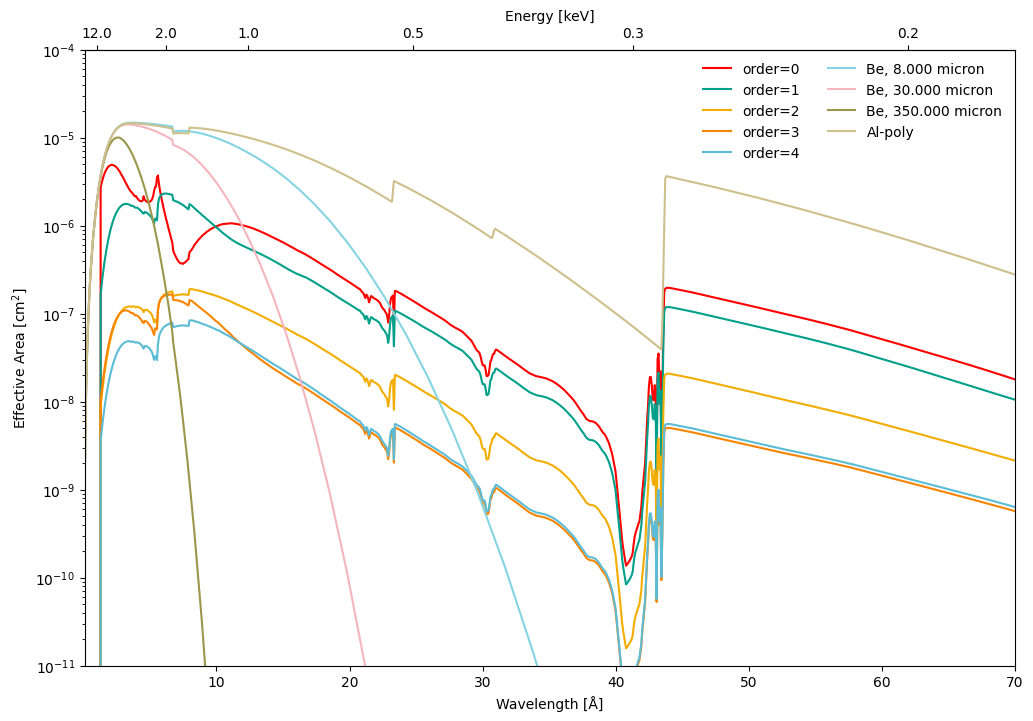

In [596]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
for chan,color in zip(dispersed_channels, spectral_palette):
    ax.plot(chan.wavelength, chan.effective_area, color=color, label=f'order={chan.spectral_order}')
for chan,color in zip(filtergram_channels, filtergram_palette):
    ax.plot(chan.wavelength, chan.effective_area, color=color,
            label='Al-poly' if 'Al' in chan.filter_label else chan.filter_label)
    

wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())

ax.set_yscale('log')
ax.set_xlim(.1,70)
ax.set_ylim(1e-11,1e-4)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Effective Area [cm$^2$]')

secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])

ax.legend(frameon=False,ncol=2)

## Spectral Map

In [660]:
spectral_table = SpectralModel().spectral_table

In [669]:
spectral_table.axis_world_coords()[1].to('MK')

<Quantity [ 0.1       ,  0.11220185,  0.12589254,  0.14125375,  0.15848932,
            0.17782794,  0.19952623,  0.22387211,  0.25118864,  0.28183829,
            0.31622777,  0.35481339,  0.39810717,  0.44668359,  0.50118723,
            0.56234133,  0.63095734,  0.70794578,  0.79432823,  0.89125094,
            1.        ,  1.12201845,  1.25892541,  1.41253754,  1.58489319,
            1.77827941,  1.99526231,  2.23872114,  2.51188643,  2.81838293,
            3.16227766,  3.54813389,  3.98107171,  4.46683592,  5.01187234,
            5.62341325,  6.30957344,  7.07945784,  7.94328235,  8.91250938,
           10.        , 11.22018454, 12.58925412, 14.12537545, 15.84893192,
           17.7827941 , 19.95262315, 22.38721139, 25.11886432, 28.18382931,
           31.6227766 , 35.48133892, 39.81071706, 44.66835922, 50.11872336,
           56.23413252, 63.09573445, 70.79457844, 79.43282347, 89.12509381] MK>

In [782]:
1050/700

1.5

(20.000000000000068, 49.528118210228065)

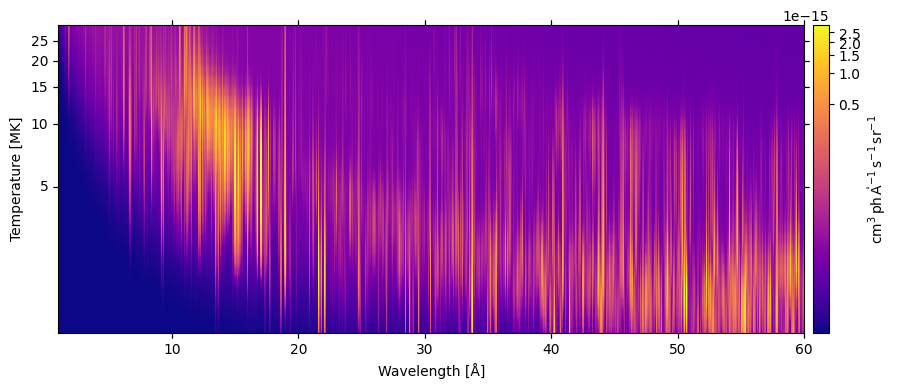

In [741]:
fig = plt.figure(figsize=(12,4))
vmin, vmax = AsymmetricPercentileInterval(1,99).get_limits(spectral_table.data)
ax = spectral_table.plot(aspect=15,
                         norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
                         axes_units=('MK', 'AA'),
                         cmap='plasma')
cb = fig.colorbar(ax.get_images()[0], ax=ax, pad=0.01)
cb.set_label(spectral_table.unit.to_string(format='latex_inline'))
ax.coords[0].set_axislabel('Wavelength [Å]')
ax.coords[1].set_axislabel('Temperature [MK]')
ax.set_xlim(spectral_table.wcs.world_to_pixel([1,60]*u.AA, 1*u.MK)[0])
ax.set_ylim(spectral_table.wcs.world_to_pixel(1*u.AA, [1,30]*u.MK)[1])

In [684]:
spectral_table.unit

Unit("cm3 ph / (Angstrom s sr)")

### Full Detector

In [747]:
sorted((observed_data_dir / 'overlappograms_full_disk').glob('*.fits'))

[PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order-1.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order-2.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order-3.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order-4.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order0.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order1.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order2.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk/overlappogram-order3.fits'),
 PosixPath('../data/observations/ar_2020-11-09T18:00:00.000/overlappograms_full_disk

In [769]:
dispersed_components = [read_overlappogram(f) for f in sorted((observed_data_dir / 'overlappograms_full_disk').glob('*.fits'))]

In [770]:
filtergram_components = [read_overlappogram(f) for f in sorted((observed_data_dir / 'filtergrams_full_disk').glob('*.fits'))]

In [771]:
full_detector = stack_components(dispersed_components+filtergram_components)

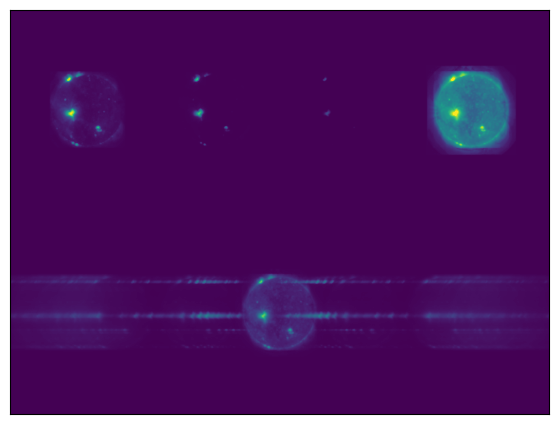

In [775]:
width = 7
fig = plt.figure(figsize=(width,0.75*width))
ax = fig.add_subplot(projection=full_detector[0].wcs)
vmin,vmax = AsymmetricPercentileInterval(1,99.99).get_limits(full_detector[0].data)
full_detector[0].plot(
    axes=ax,
    norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),
    cmap='viridis',
    interpolation='gaussian',
)
for c in ax.coords:
    c.set_ticks_visible(False)
    c.set_ticklabel_visible(False)

In [778]:
stacked_dispersed = stack_components(dispersed_components, wcs_index=5)
stacked_filtergrams = stack_components(filtergram_components)

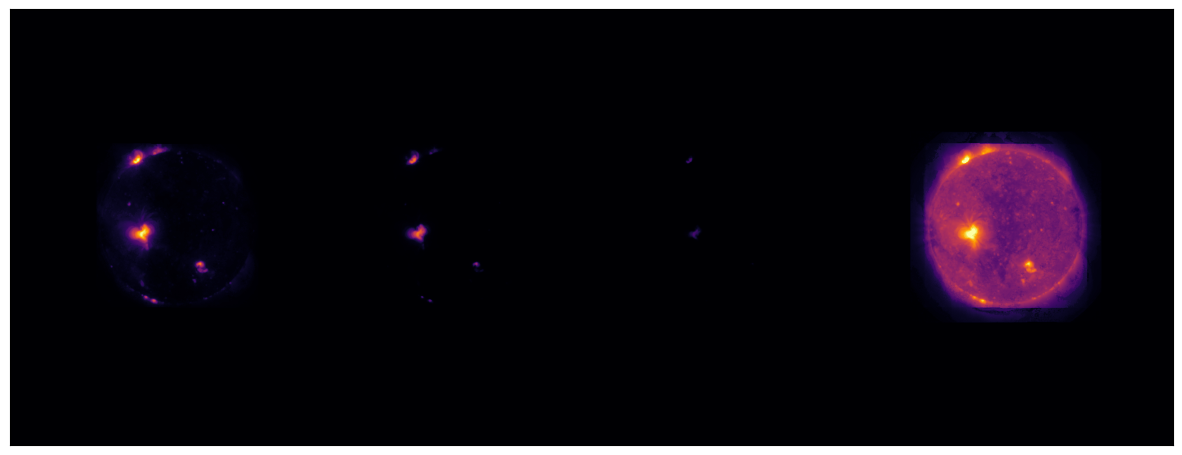

In [657]:
width = 15
fig = plt.figure(figsize=(width,0.75*width))
sl = np.s_[0,750:,:]
ax = fig.add_subplot(projection=stacked_filtergrams[sl].wcs)
vmin, vmax = AsymmetricPercentileInterval(1,99.99).get_limits(stacked_filtergrams[sl].data)
stacked_filtergrams[sl].plot(axes=ax, norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),cmap='inferno')
#color_lat_lon_axes(ax)
#add_arrow_from_coords(ax, (-1200,0)*u.arcsec, (-1200, 750)*u.arcsec, color='w', mutation_scale=15,)
turn_off_ticks_and_labels(ax)
fig.savefig('/Users/wtbarnes/Desktop/moxsi-filtergram.pdf',bbox_inches='tight')

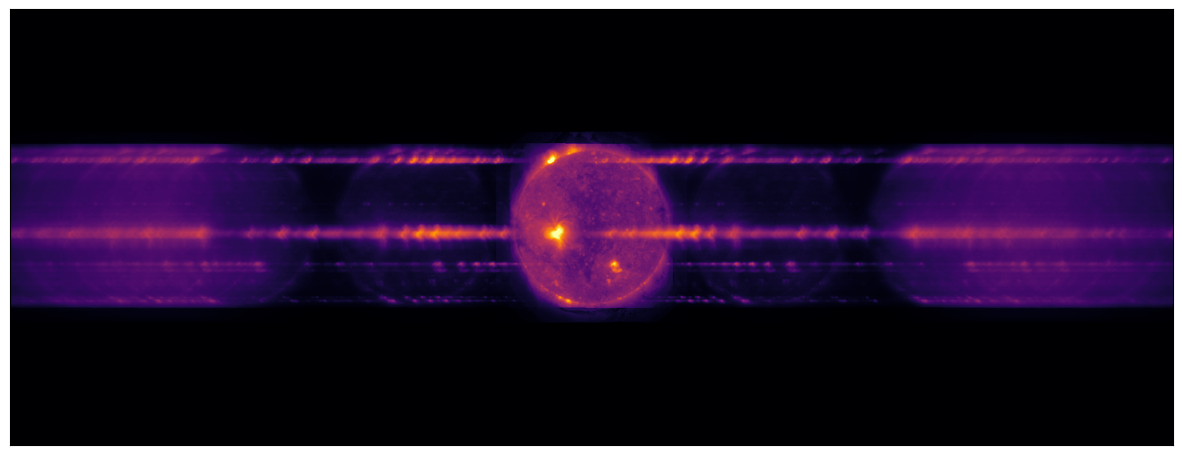

In [658]:
width = 15
fig = plt.figure(figsize=(width,0.75*width))
sl = np.s_[0,:750,:]
ax = fig.add_subplot(projection=stacked_dispersed[sl].wcs)
vmin, vmax = AsymmetricPercentileInterval(1,99.99).get_limits(stacked_dispersed[sl].data)
stacked_dispersed[sl].plot(axes=ax, norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),cmap='inferno')
#color_lat_lon_axes(ax)
#add_arrow_from_coords(ax, (-1200,0)*u.arcsec, (-1200, 750)*u.arcsec, color='w', mutation_scale=15,)
turn_off_ticks_and_labels(ax)
fig.savefig('/Users/wtbarnes/Desktop/moxsi-spectrogram.pdf',bbox_inches='tight')

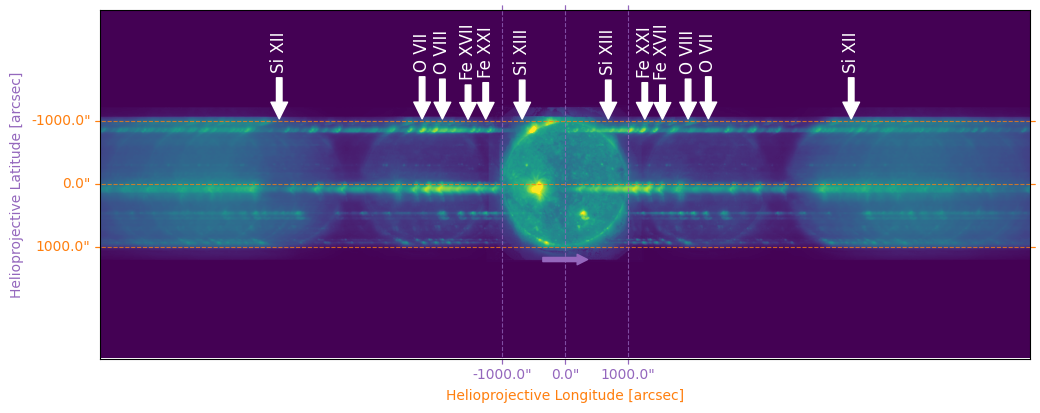

In [780]:
width = 12
fig = plt.figure(figsize=(width,0.75*width))
sl = np.s_[0,:750,:]
ax = fig.add_subplot(projection=stacked_dispersed[sl].wcs)
vmin,vmax = AsymmetricPercentileInterval(1,99.97).get_limits(stacked_dispersed[sl].data)
stacked_dispersed[sl].plot(axes=ax, norm=ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch()),cmap='viridis')
#color_lat_lon_axes(ax)
add_arrow_from_coords(ax, (1200,-400)*u.arcsec, (1200, 400)*u.arcsec, color='C4', mutation_scale=15,)
color_lat_lon_axes(ax, lon_color='C1', lat_color='C4')
for c in ax.coords:
    c.set_ticks(([-1000,0,1000]*u.arcsec).to('deg'))
    c.grid(ls='--', alpha=0.75)
ax.coords[0].set_axislabel('Helioprojective Longitude [arcsec]')
ax.coords[1].set_axislabel('Helioprojective Latitude [arcsec]')

# Add wavelength annotations
annot_pt = SkyCoord(Tx=-1000*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(stacked_dispersed.wcs))
line_indices = [1, 3, 10, 12, 16, 18]
for line in selected_lines[line_indices]:
    pix_x, pix_y, _ = stacked_dispersed.wcs.world_to_pixel(annot_pt, line['wavelength'])
    ax.annotate(f'{line["ion name"]}',
                xy=(pix_x, pix_y),  # theta, radius
                xytext=(0, 50),    # fraction, fraction
                textcoords='offset points',
                color='w',
                arrowprops=dict(color='w', shrink=0.05),
                horizontalalignment='center',
                verticalalignment='center',
                rotation=90,
                fontsize=12)
for line in selected_lines[line_indices]:
    pix_x, pix_y, _ = stack_components(dispersed_components, wcs_index=0).wcs.world_to_pixel(annot_pt, line['wavelength'])
    ax.annotate(f'{line["ion name"]}',
                xy=(pix_x, pix_y),  # theta, radius
                xytext=(0, 50),    # fraction, fraction
                textcoords='offset points',
                color='w',
                arrowprops=dict(color='w', shrink=0.05),
                horizontalalignment='center',
                verticalalignment='center',
                rotation=90,
                fontsize=12)

### Zoom-in to AR
(separate by order)

In [809]:
upper_tick

112.4

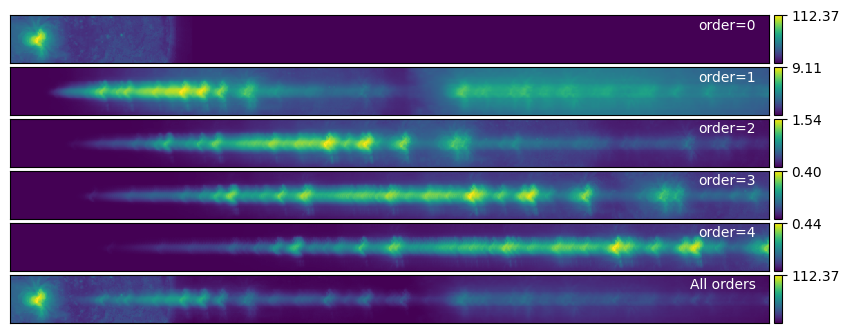

In [815]:
width = 12
fig = plt.figure(figsize=(width,width/3))
sl = np.s_[0,330:400,900:]
labels = [f'order={i}' for i in range(5)] + ['All orders', ]
data_unit = 'ph/pix/h'
for i,ol in enumerate(dispersed_components[4:]+[stacked_dispersed,] ):
    ax = fig.add_subplot(6,1,i+1,projection=ol[sl].wcs)
    vmin,vmax = AsymmetricPercentileInterval(2,99.99).get_limits(ol[sl].to(data_unit).data)
    norm = ImageNormalize(vmin=vmin,vmax=vmax,stretch=LogStretch())
    ol[sl].plot(axes=ax, norm=norm,cmap='viridis',data_unit=data_unit,interpolation='none')
    ax.text(1080, 65, labels[i],
            horizontalalignment='right',
            verticalalignment='top',
            color='w')
    turn_off_ticks_and_labels(ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='1%', pad=0.05, axes_class=matplotlib.axes.Axes)
    upper_tick = float(f'{vmax:.1f}')
    cbar = fig.colorbar(ax.get_images()[0], cax=cax, orientation='vertical', ticks=[vmax])
    cax.yaxis.set_ticks_position("right")
    cbar.formatter = ticker.StrMethodFormatter("{x:.2f}")
    #cbar.locator = ticker.MaxNLocator(nbins=0, prune='lower')
    cbar.update_ticks()
#color_lat_lon_axes(ax)
plt.subplots_adjust(hspace=0.075)

### Summed Spectra

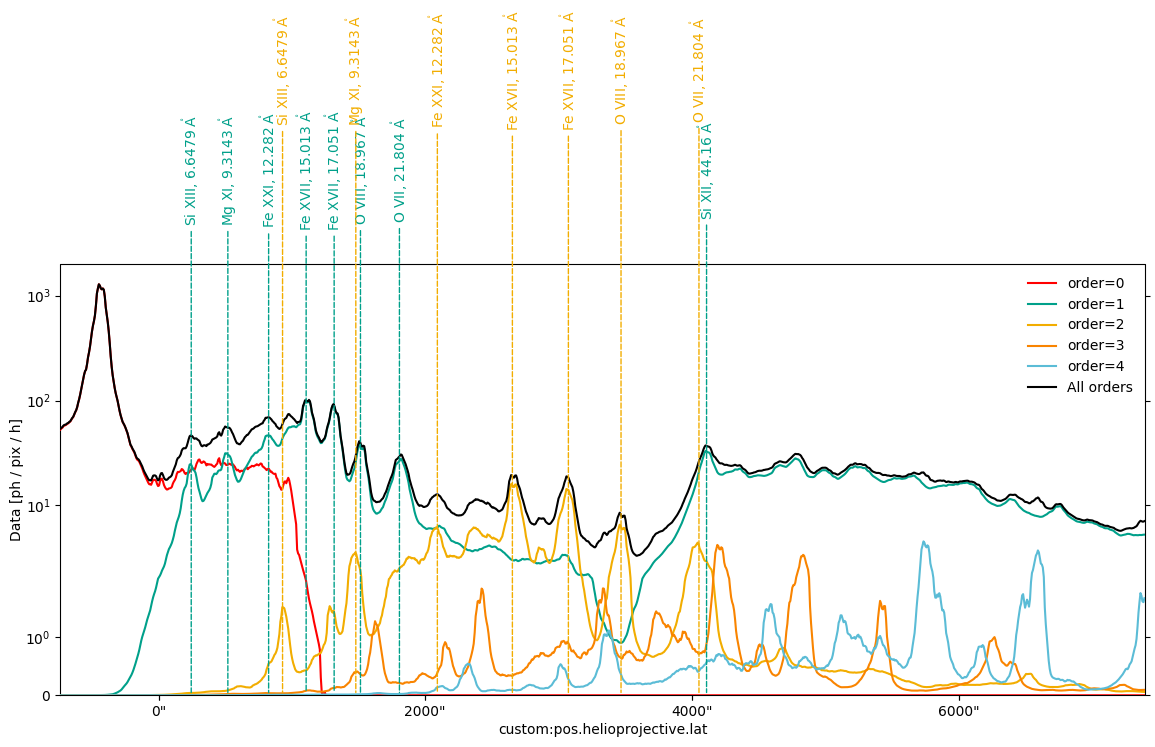

In [867]:
width = 14
fig = plt.figure(figsize=(width,width*0.4))
#sl = np.s_[0,290:330,980:]
sl = np.s_[0,330:400,900:]
labels = [f'order={i}' for i in range(5)] + ['All orders', ]
data_unit = 'ph / pix / h'
ax = None
for i,ol in enumerate(dispersed_components[4:]+[stacked_dispersed,] ):
    rebin_total = ol[sl].rebin((ol[sl].data.shape[0], 1),operation=np.sum)[0]
    if ax is None:
        ax = fig.add_subplot(projection=rebin_total.wcs)
    rebin_total.plot(axes=ax,
                     data_unit=data_unit,
                     label=labels[i],
                     color='k' if i==5 else spectral_palette[i])
    
# Add vertical lines denoting lines
center_loc = SkyCoord(Ty=-440*u.arcsec, Tx=0*u.arcsec, frame=wcs_to_celestial_frame(dispersed_components[0].wcs))
tick_locations = []
# Add first order labels
line_indices = [1, 3, 4, 10, 13, 15, 16, 18]
for ol, color in zip(dispersed_components[5:7], spectral_palette[1:]):
    line_pos, _, _ = ol[:,330:400,900:].wcs.world_to_pixel(center_loc, selected_lines[line_indices]['wavelength'])
    #ax.vlines(line_pos, 0, 1e5, ls=':', color=color)
    #tick_locations.append(line_pos)
    for pos, row in zip(line_pos, selected_lines[line_indices]):
        bump_up = abs(ol.meta['PC2_3'])%2 == 0
        bump = 100
        text_ypos = 525
        ax.annotate(
            f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline", precision=5)}',
            (pos, 0),
            xytext=(0, text_ypos+bump if bump_up else text_ypos),
            textcoords='offset pixels',
            #ls='--',
            rotation=90,
            color=color,
            horizontalalignment='center',
            verticalalignment='center',
            arrowprops=dict(color=color, arrowstyle='-', ls='--'),
        )

ax.set_yscale('symlog')
ax.set_ylim(0,2e3)
ax.set_xlim(0,ol[sl].data.shape[1])
ax.legend(frameon=False)
#turn_off_ticks_and_labels(ax)
#fig.savefig('/Users/wtbarnes/Desktop/moxsi-spectra-summed-ar.pdf')

In [834]:
ol.meta

FileHeader([('SIMPLE', True),
            ('BITPIX', -64),
            ('NAXIS', 3),
            ('NAXIS1', 2000),
            ('NAXIS2', 1500),
            ('WCSAXES', 3),
            ('CRPIX1', 1000.5),
            ('CRPIX2', 375.5),
            ('CRPIX3', 1.0),
            ('PC1_1', 6.1232339957368e-17),
            ('PC1_2', -1.0),
            ('PC1_3', -1.2246467991473e-16),
            ('PC2_1', 1.0),
            ('PC2_2', 6.1232339957368e-17),
            ('PC2_3', -2.0),
            ('CDELT1', 0.0020555555555556),
            ('CDELT2', 0.0020555555555556),
            ('CDELT3', 7.18e-12),
            ('CUNIT1', 'deg'),
            ('CUNIT2', 'deg'),
            ('CUNIT3', 'm'),
            ('CTYPE1', 'HPLN-TAN'),
            ('CTYPE2', 'HPLT-TAN'),
            ('CTYPE3', 'WAVE'),
            ('CRVAL1', 0.0),
            ('CRVAL2', 0.0),
            ('CRVAL3', 0.0),
            ('LONPOLE', 180.0),
            ('LATPOLE', 0.0),
            ('MJDREF', 0.0),
            ('DATE-OB

## Simulated DEM Figure

In [646]:
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1) * u.K
temperature_bin_centers = 10**((np.log10(temperature_bin_edges.value)[1:]+np.log10(temperature_bin_edges.value)[:-1])/2)*u.K
dem_cube_hf = InstrumentDEM.dem_maps_list_to_cube(
    sunpy.map.Map(sorted((simulated_data_dir / 'p0.3' / 'dem').glob('m_*_t1800.fits'))),
    temperature_bin_centers,
)
dem_cube_lf = InstrumentDEM.dem_maps_list_to_cube(
    sunpy.map.Map(sorted((simulated_data_dir / 'p0.005' / 'dem').glob('m_*_t1800.fits'))),
    temperature_bin_centers,
)

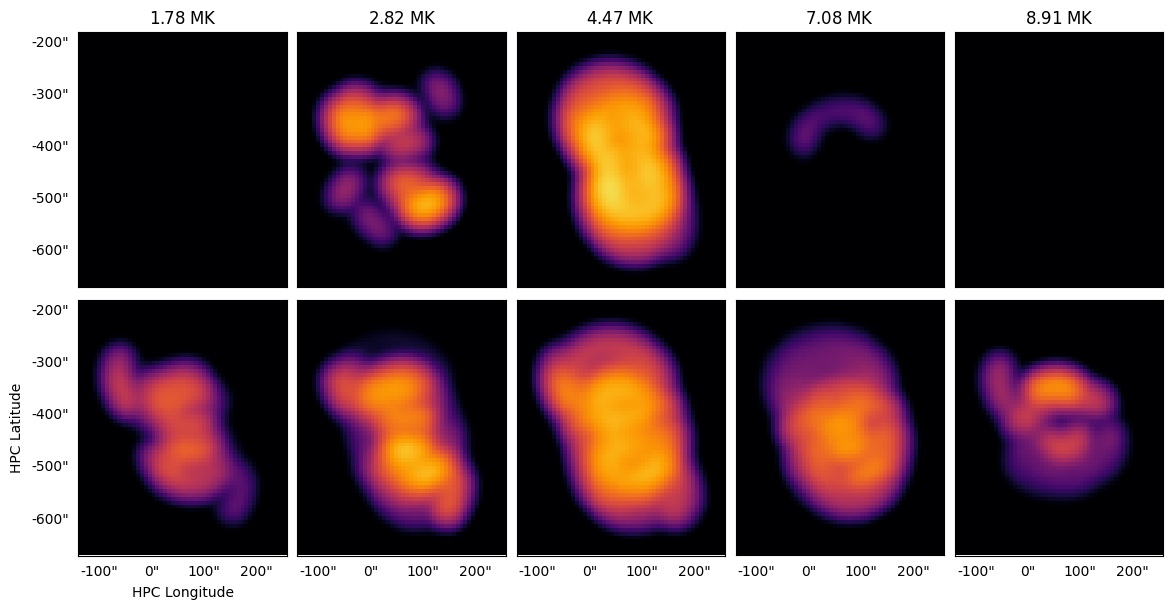

In [892]:
norm = ImageNormalize(vmin=1e24, vmax=5e27, stretch=LogStretch())
fig = plt.figure(figsize=(14,6.8))
dem_indices = [7, 9, 11, 13, 14]
for i,idem in enumerate(dem_indices):
    ax = fig.add_subplot(2,len(dem_indices),i+1, projection=dem_cube_hf[idem].wcs)
    dem_cube_hf[idem].plot(axes=ax, norm=norm, cmap='inferno')
    ax.set_title(temperature_bin_centers[idem].to('MK').to_string(format='latex_inline', precision=3))
    ax.coords[0].set_axislabel(' ')
    ax.coords[1].set_axislabel(' ')
    ax.coords[0].set_ticklabel_visible(False)
    if i > 0:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
    ax = fig.add_subplot(2,len(dem_indices),i+len(dem_indices)+1, projection=dem_cube_lf[idem].wcs)
    dem_cube_lf[idem].plot(axes=ax, norm=norm, cmap='inferno')
    if i == 0:
        ax.coords[0].set_axislabel('HPC Longitude')
        ax.coords[1].set_axislabel('HPC Latitude')
    else:
        ax.coords[0].set_axislabel(' ')
        ax.coords[1].set_axislabel(' ')
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

## Simulated spectra summary figure

In [927]:
spec_cube_hf = read_data_cube(simulated_data_dir / 'p0.3' / 'spectra' / 'spec_cube_t1000.fits')
spec_cube_lf = read_data_cube(simulated_data_dir / 'p0.005' / 'spectra' / 'spec_cube_t1000.fits')

In [941]:
spec_cube_hf

NDCube
------
Dimensions: [2000.   66.   54.] pix
Physical Types of Axes: [('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: ph / (Angstrom cm2 s sr)
Data Type: >f8

(0.0, 10.0)

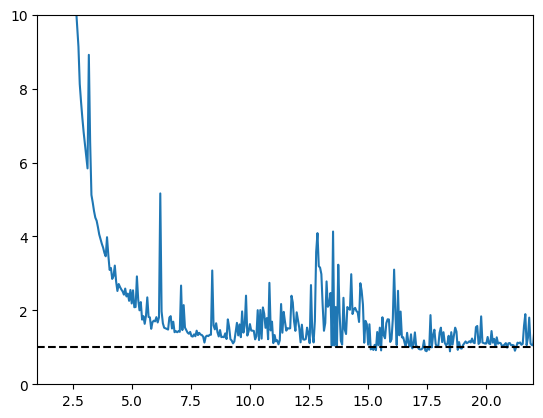

In [943]:
plt.plot(spec_cube_hf.axis_world_coords(0)[0].to('AA'),
         spec_cube_lf[:,20:40,20:30].data.sum(axis=(1,2)) / spec_cube_hf[:,20:40,20:30].data.sum(axis=(1,2)))
plt.axhline(y=1, color='k', ls='--')
plt.xlim(1,22)
#plt.yscale('log')
#plt.ylim(1e12,3e16)
plt.ylim(0,10)

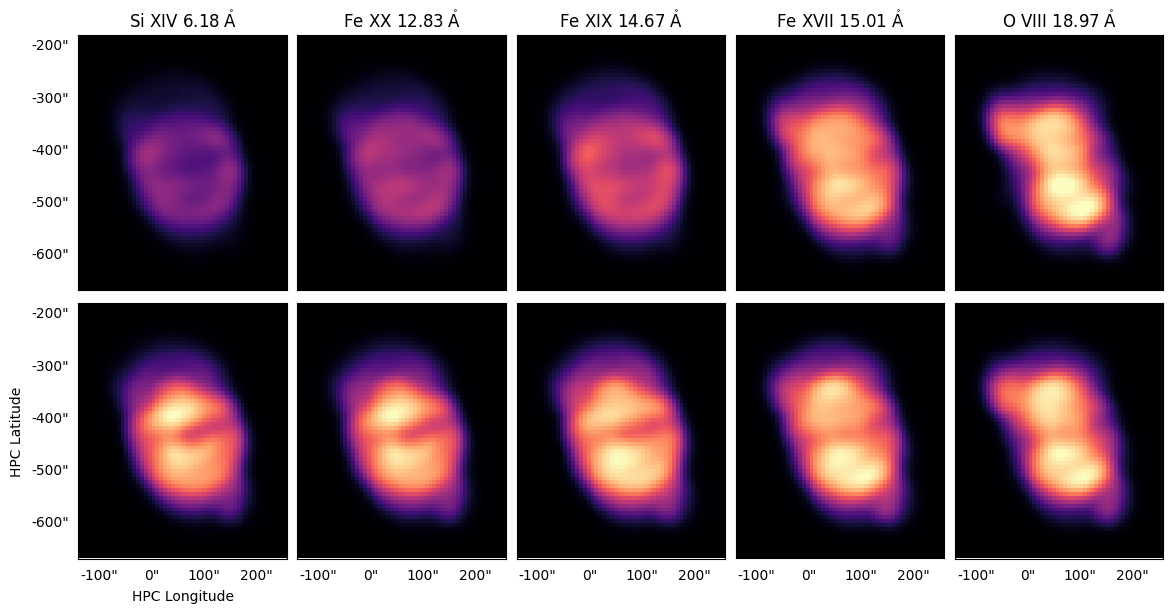

In [955]:
line_indices = [0, 9, 2, 3, 10]
fig = plt.figure(figsize=(14,6.8))
for i, row in enumerate(selected_lines[line_indices]):
    iwave = int(np.argmin(np.fabs(row['wavelength'] - spec_cube_hf.axis_world_coords(0)[0])))
    ax = fig.add_subplot(2,len(line_indices), i+1, projection=spec_cube_hf[iwave].wcs)
    vmin,vmax = AsymmetricPercentileInterval(2,99.99).get_limits(spec_cube_lf[iwave].data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    spec_cube_hf[iwave].plot(axes=ax, norm=norm, cmap='magma')
    ax.set_title(f'{row["ion name"]} {row["wavelength"].to("AA").to_string(format="latex_inline", precision=4)}')
    ax.coords[0].set_axislabel(' ')
    ax.coords[1].set_axislabel(' ')
    ax.coords[0].set_ticklabel_visible(False)
    if i > 0:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
    ax = fig.add_subplot(2,len(line_indices),i+len(line_indices)+1, projection=spec_cube_lf[iwave].wcs)
    spec_cube_lf[iwave].plot(axes=ax, norm=norm, cmap='magma')
    if i == 0:
        ax.coords[0].set_axislabel('HPC Longitude')
        ax.coords[1].set_axislabel('HPC Latitude')
    else:
        ax.coords[0].set_axislabel(' ')
        ax.coords[1].set_axislabel(' ')
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks(color='w')
    ax.coords[1].set_ticks(color='w')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

## Slitless Spectra Images

In [19]:
frequencies = [
    0.3,
    #0.05,
    #0.01,
    0.005
]
data_unit = u.Unit('photon')

In [31]:
simulated_overlappograms = [
    [read_overlappogram(file) for file in (simulated_data_dir / f'p{freq}' / 'overlappograms').glob('overlappogram_o*.fits')]
    for freq in frequencies
]

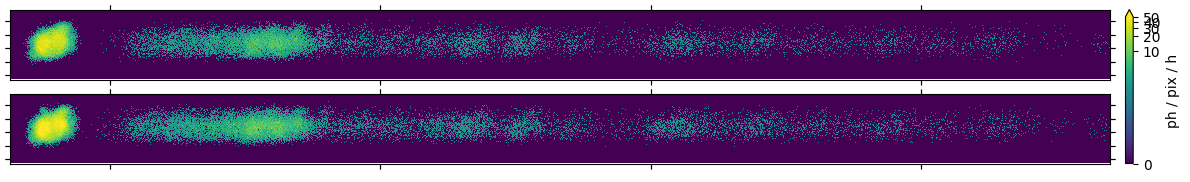

In [959]:
fig = plt.figure(figsize=(20,2))
axes = []
for i, overlaps in enumerate(simulated_overlappograms):
    cropped_cube = stack_components(overlaps)[0,330:400,900:]
    ax = fig.add_subplot(2,1,i+1, projection=cropped_cube.wcs)
    cropped_cube.plot(
        axes=ax,
        norm=ImageNormalize(vmin=0, vmax=50, stretch=LogStretch()),
        data_unit='ph',
        cmap='viridis',
        interpolation='none'
    )
    #color_lat_lon_axes(ax)
    axes.append(ax)
cb = fig.colorbar(ax.get_images()[0], extend='max', ax=axes, pad=0.01)
cb.set_label(data_unit)

In [965]:
ar_center = SkyCoord(Tx=50*u.arcsec,Ty=-505*u.arcsec,frame=wcs_to_celestial_frame(simulated_overlappograms[0][0].wcs))

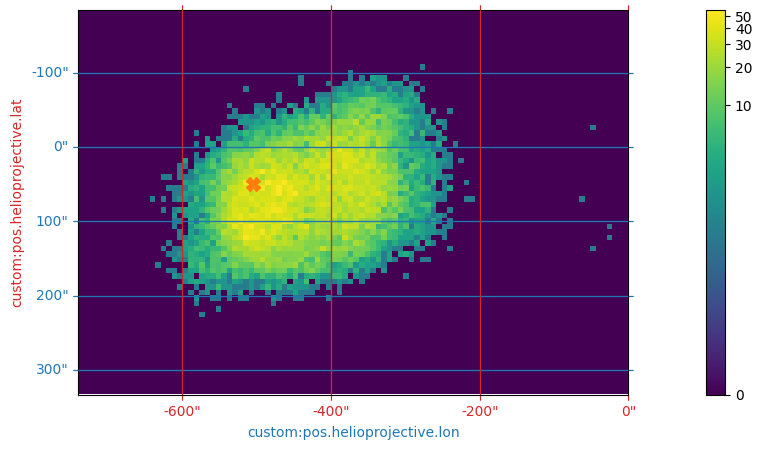

In [966]:
plt.figure(figsize=(20,5))
ax = stack_components(simulated_overlappograms[0])[0,330:400,900:1000].plot(norm=ImageNormalize(stretch=LogStretch()), interpolation='none')
color_lat_lon_axes(ax)
ax.plot_coord(ar_center, marker='X', color='C1', markersize=10)
plt.colorbar()

## Summed Spectra

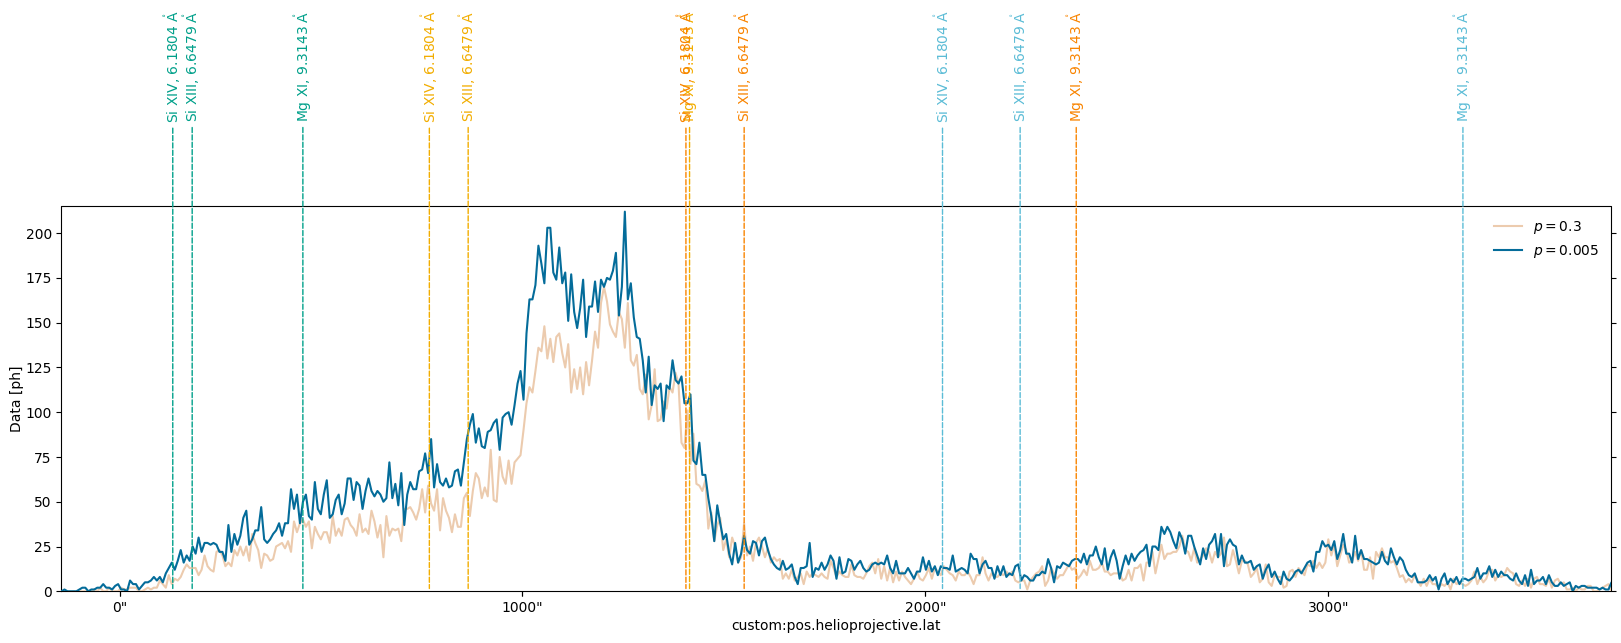

In [1025]:
fig = plt.figure(figsize=(20,5))
ax = None
for ol, freq, color in zip(simulated_overlappograms, frequencies, frequency_palette):
    ol_stacked = stack_components(ol)
    total_rebin = ol_stacked[0].rebin((ol_stacked[0].data.shape[0], 1),operation=np.sum)[0]
    if ax is None:
        ax = fig.add_subplot(projection=total_rebin)
    total_rebin.plot(axes=ax, ls='-', data_unit='ph', label=f'$p={freq}$', color=color)

ion_list = ['Fe XVII', 'Fe XVIII', 'Fe XIX', 'Fe XXI']
fe_lines = selected_lines[[r in ['Si', 'Mg'] for r in selected_lines['element']]]
#fe_lines = selected_lines[selected_lines['element']'Si']
for ol, color in zip(simulated_overlappograms[0][1:], spectral_palette[1:]):
    line_pos, _, _ = ol.wcs.world_to_pixel(ar_center, fe_lines['wavelength'])
    for pos, row in zip(line_pos, fe_lines):
        bump_up = abs(ol.meta['PC2_3'])%2 == 0
        bump = 0
        text_ypos = 525
        ax.annotate(
            f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline", precision=5)}',
            (pos, 0),
            xytext=(0, text_ypos+bump if bump_up else text_ypos),
            textcoords='offset pixels',
            #ls='--',
            rotation=90,
            color=color,
            horizontalalignment='center',
            verticalalignment='center',
            arrowprops=dict(color=color, arrowstyle='-', ls='--'),
        )
        
#ax.coords[1].set_ticks_visible(False)
#ax.coords[1].set_ticklabel_visible(False)

#ax.set_yscale('symlog')
#ax.set_ylim(0, 70)
ax.set_ylim(0,215)
ax.set_xlim(980,1500)
#ax.set_xlim(1190,1600)
#ax.set_xlim(1050,1250)
#ax.set_xlim(1100,1300)

source_pos,_,_ = simulated_overlappograms[0][0].wcs.world_to_pixel(ar_center, 1*u.angstrom)
ax.axvline(x=source_pos, ls='--', color='k')

#ax.vlines(np.where(diff.data>6)[0], 0, 1e4, ls='--', color='k')

ax.legend(frameon=False)

In [237]:
ol_hf = stack_components(simulated_overlappograms[0])
ol_hf = ol_hf[0].rebin((ol_hf[0].data.shape[0], 1),operation=np.sum)[0]
ol_lf = stack_components(simulated_overlappograms[1])
ol_lf = ol_lf[0].rebin((ol_lf[0].data.shape[0], 1),operation=np.sum)[0]

In [255]:
diff = ol_lf.data / ol_hf.data - 1.0
diff = ndcube.NDCube(diff, ol_lf.wcs, mask=np.fabs(diff)<.5)

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_91709/297373965.py:1: RuntimeWarning: divide by zero encountered in divide
  diff = ol_lf.data / ol_hf.data - 1.0
/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_91709/297373965.py:1: RuntimeWarning: invalid value encountered in divide
  diff = ol_lf.data / ol_hf.data - 1.0


<WCSAxesSubplot:ylabel='Data'>

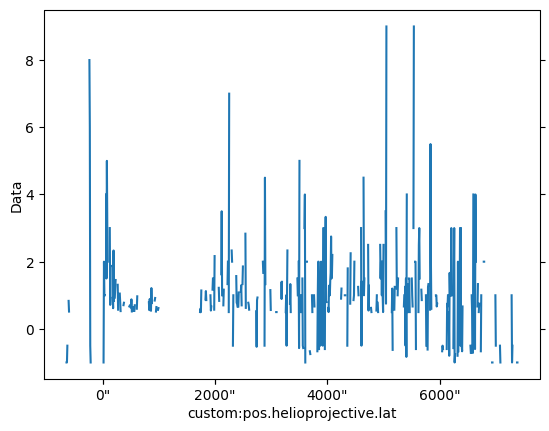

In [265]:
diff.plot()

In [267]:
np.where(diff.data>6)

(array([ 968,  972,  976,  981,  986,  987,  988,  990,  992,  994,  995,
         997,  998,  999, 1006, 1007, 1304, 1488, 1494, 1495, 1500, 1510,
        1606, 1678, 1682, 1699, 1748, 1810, 1814, 1850, 1870, 1911, 1918,
        1919, 1921, 1923, 1926, 1927, 1929, 1935, 1939, 1940, 1941, 1942,
        1946, 1952, 1957, 1961, 1963, 1973, 1975, 1976, 1977, 1978, 1979,
        1980, 1982, 1986, 1992, 1994, 1998]),)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:668: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:668: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:668: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:668: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn(


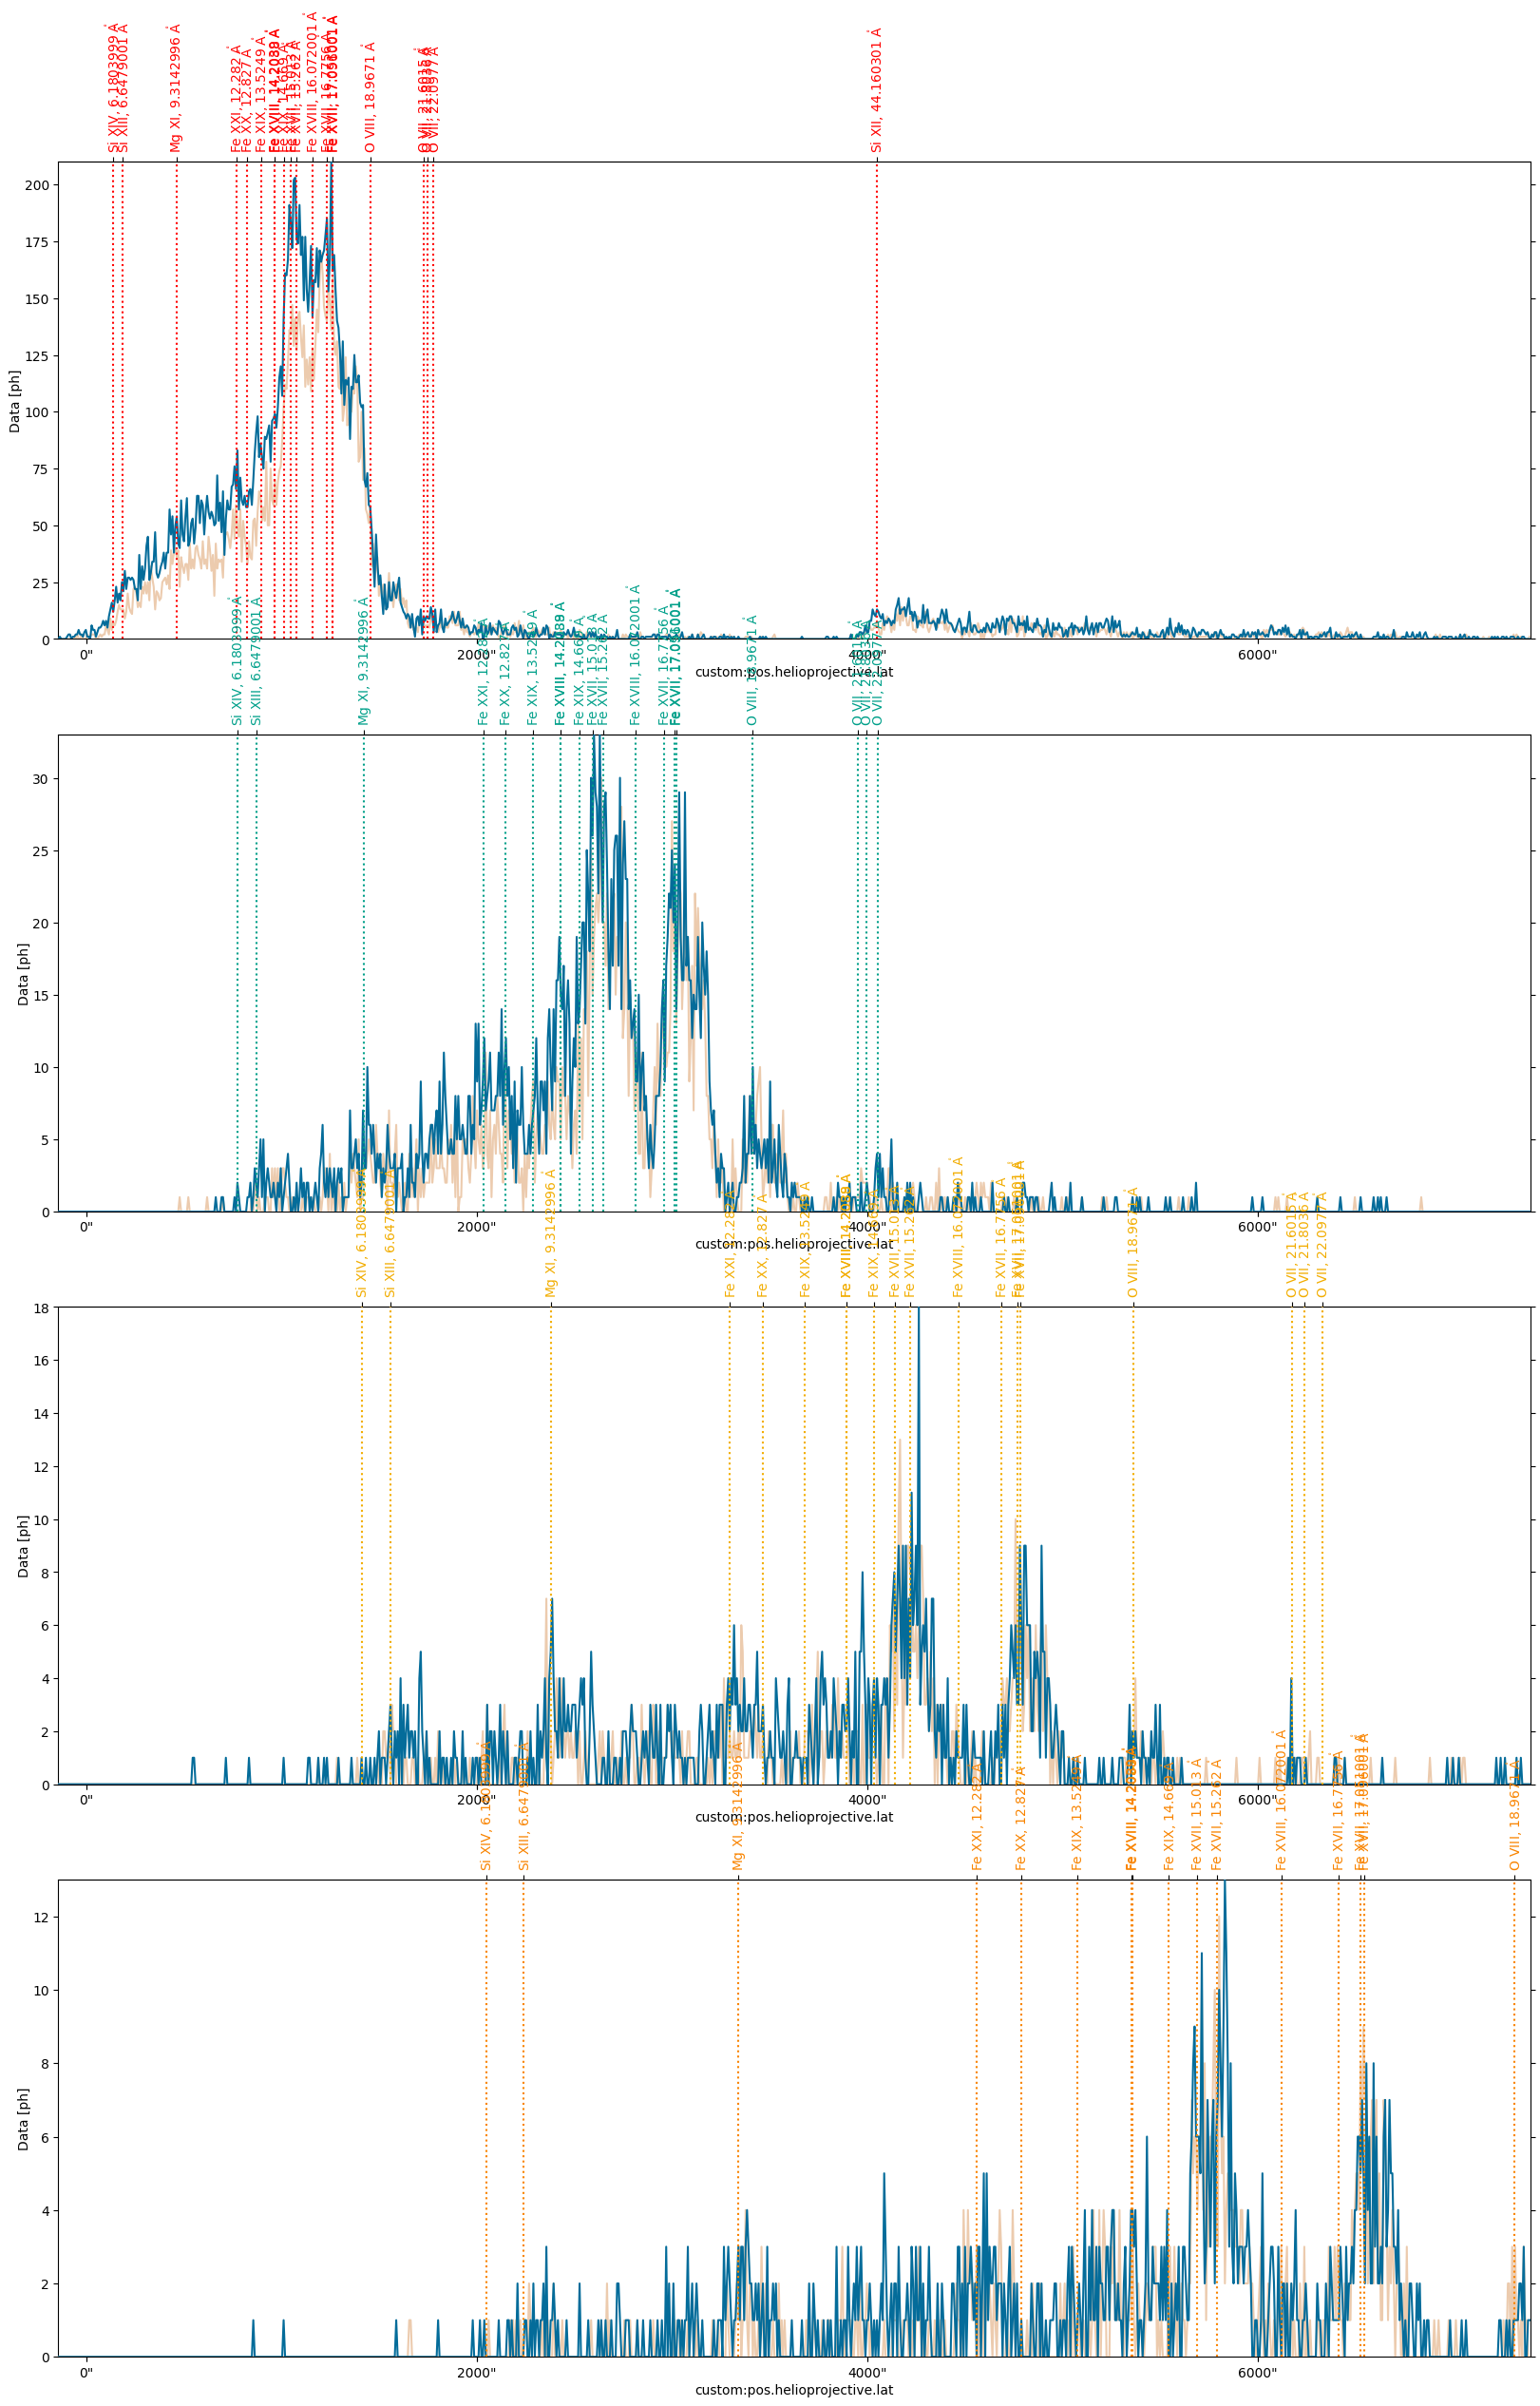

In [373]:
fig = plt.figure(figsize=(20,30))
for i in range(1,5):
    ax = None
    for ol, freq, color in zip(simulated_overlappograms, frequencies, frequency_palette):
        ol_stacked = ol[i]
        total_rebin = ol_stacked[0].rebin((ol_stacked[0].data.shape[0], 1),operation=np.sum)[0]
        if ax is None:
            ax = fig.add_subplot(4,1,i,projection=total_rebin)
        total_rebin.plot(axes=ax, ls='-', data_unit=data_unit, label=f'$p={freq}$', color=color)
        
    # Add vertical lines denoting lines
    tick_locations,_,_ = ol[i].wcs.world_to_pixel(ar_center, selected_lines['wavelength'])
    ax.vlines(tick_locations, 0, 1e4, ls=':', color=spectral_palette[i-1])
    # Add tick labels for lines
    tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in selected_lines]
    ax_top = ax.secondary_xaxis('top') 
    ax_top.set_xticks(tick_locations,
                      labels=tick_labels,
                      rotation=90,
                      horizontalalignment='center',
                      color='k');
    for _, tick in enumerate(ax_top.get_xticklabels()):
        tick.set_color(spectral_palette[i-1])
        
    #ax.set_yscale('symlog')
    ax.set_ylim(0, total_rebin.data.max())
    ax.set_xlim(980,2000)

## Contribution Functions

In [3]:
import fiasco
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [52]:
temperature = 10**np.arange(6,7.5,0.05)*u.K
density = 1e15*u.Unit('K cm-3') / temperature
ions = {iname: fiasco.Ion(iname, temperature) for iname in np.unique(selected_lines['ion name'])}
goft = {k: v.contribution_function(density, couple_density_to_temperature=True) for k,v in ions.items()}

In [53]:
element_colors = {name: color for name, color in zip(np.unique(selected_lines['element']), wesanderson.color_palettes['Fantastic Mr. Fox'][0][1:])}

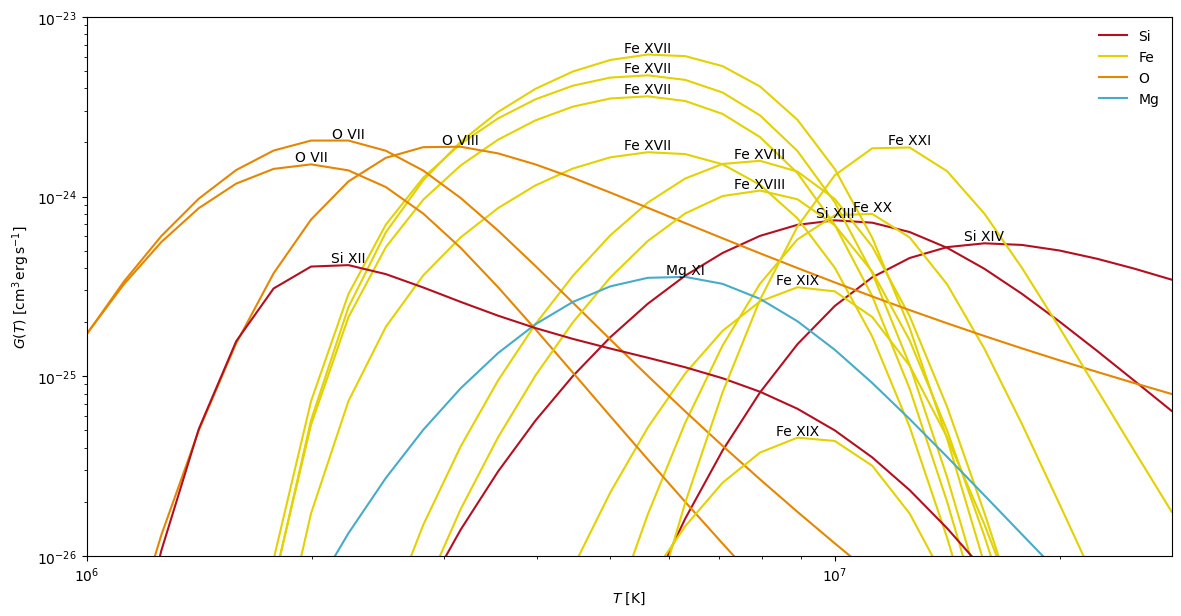

In [55]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
for row in selected_lines:
    waves = ions[row['ion name']].transitions.wavelength[~ions[row['ion name']].transitions.is_twophoton]
    iwave = int(np.argmin(np.fabs(waves-row['wavelength'])))
    _goft = goft[row['ion name']][...,iwave].squeeze()
    ax.plot(temperature, _goft, color=element_colors[row['element']], label=row['element'])
    ax.text(temperature[_goft.argmax()].value, _goft.max().value, row['ion name'],
            horizontalalignment='center', verticalalignment='bottom', clip_on=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-23)
ax.set_xlim(temperature[[0,-1]].value)
ax.set_xlabel('$T$ [K]')
ax.set_ylabel(f'$G(T)$ [{_goft.unit.to_string(format="latex_inline")}]')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)

In [56]:
foo = read_data_cube('../pipeline/data/p0.005/spectra/spec_cube_t1001.fits')

In [57]:
import sunpy.io._fits as sunpy_fits

In [59]:
sunpy_fits.write('/Users/wtbarnes/Desktop/compressed-spectral-cube-test.fits',
                 foo.data,
                 foo.meta,
                 hdu_type=astropy.io.fits.CompImageHDU,
                 overwrite=True)